In [1]:
import json
from pathlib import Path
from importlib import reload
import shapely

# own imports
#import segment_geometry as sg
import parse_geojson as pg

In [2]:
# Define the woring directory and filename
data_dir = Path("data", "clean")

paths = []

for i in range(9):
    paths.append(data_dir / f"Output{i}_clean.geojson")

# Load the segments
segments = []
transform_parameters = []
for i, path in enumerate(paths):
    segment, transform_parameter = pg.load_segments(path)
    segments.append(segment)
    transform_parameters.append(transform_parameter)
    print(f"Map number {i} has been loaded")
    print(f"   Saved parameters for inverse transformation are: {transform_parameter}")
    print(f"   Has loaded {len(segment.geoms)} segments, total {segment.length:.0f}m, mean length {segment.length/len(segment.geoms):.4f}m")


Map number 0 has been loaded
   Saved parameters for inverse transformation are: [-96597.65433833403, -82411.47514528442, 0.001]
   Has loaded 5681 segments, total 5312m, mean length 0.9350m
Map number 1 has been loaded
   Saved parameters for inverse transformation are: [558.2739391964515, 440.1539349014174, 0.001]
   Has loaded 1952 segments, total 7243m, mean length 3.7103m
Map number 2 has been loaded
   Saved parameters for inverse transformation are: [-378955.8177593881, 339833.89240163006, 0.001]
   Has loaded 22425 segments, total 2667m, mean length 0.1189m
Map number 3 has been loaded
   Saved parameters for inverse transformation are: [9.35511591685751, 8.81088134718489, 1]
   Has loaded 520 segments, total 1679m, mean length 3.2286m
Map number 4 has been loaded
   Saved parameters for inverse transformation are: [-150.52902158125835, 254.19004458300458, 0.001]
   Has loaded 964 segments, total 1776m, mean length 1.8423m
Map number 5 has been loaded
   Saved parameters for in

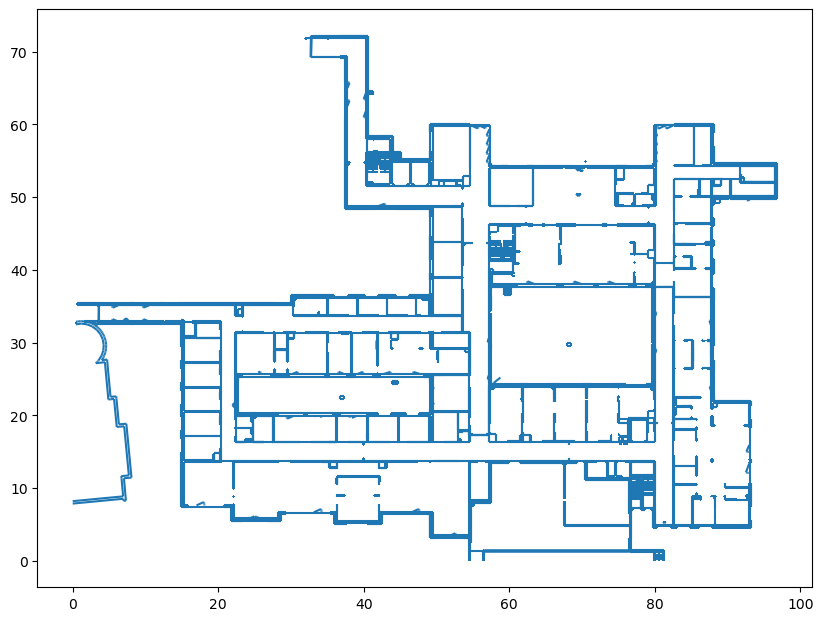

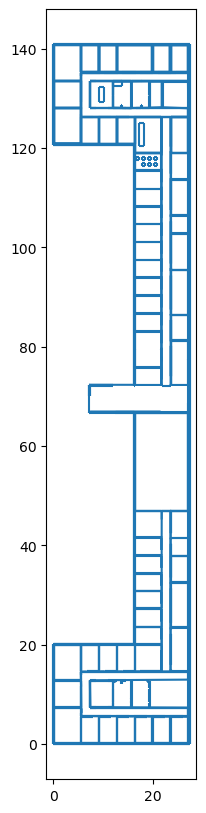

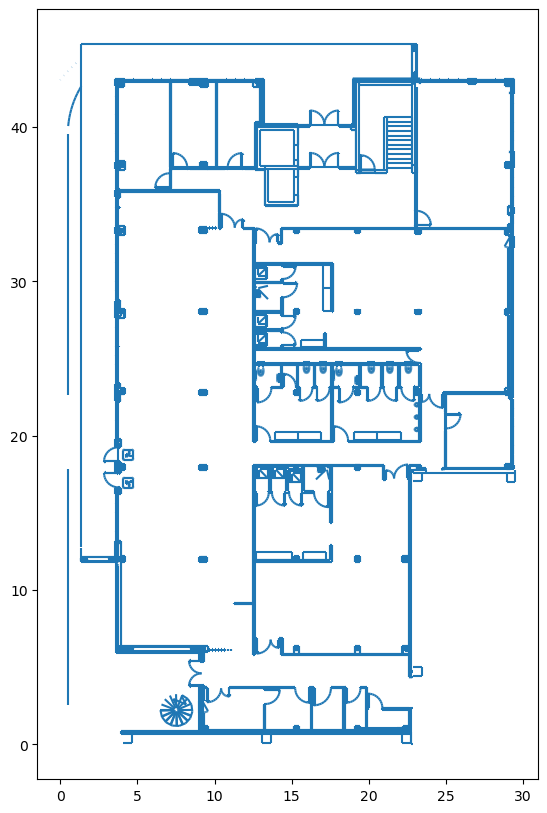

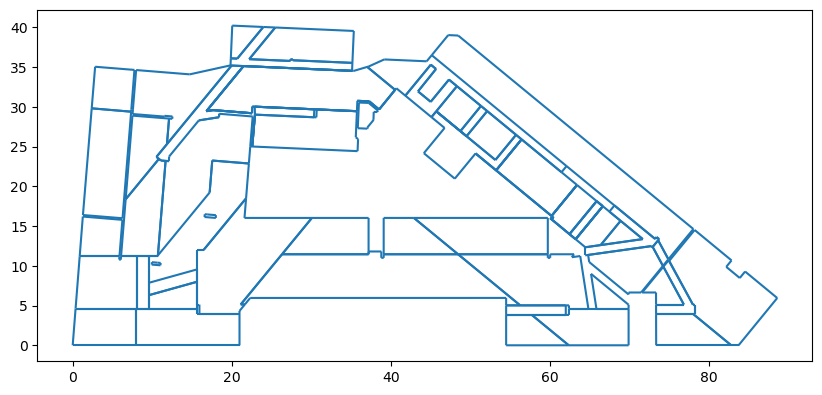

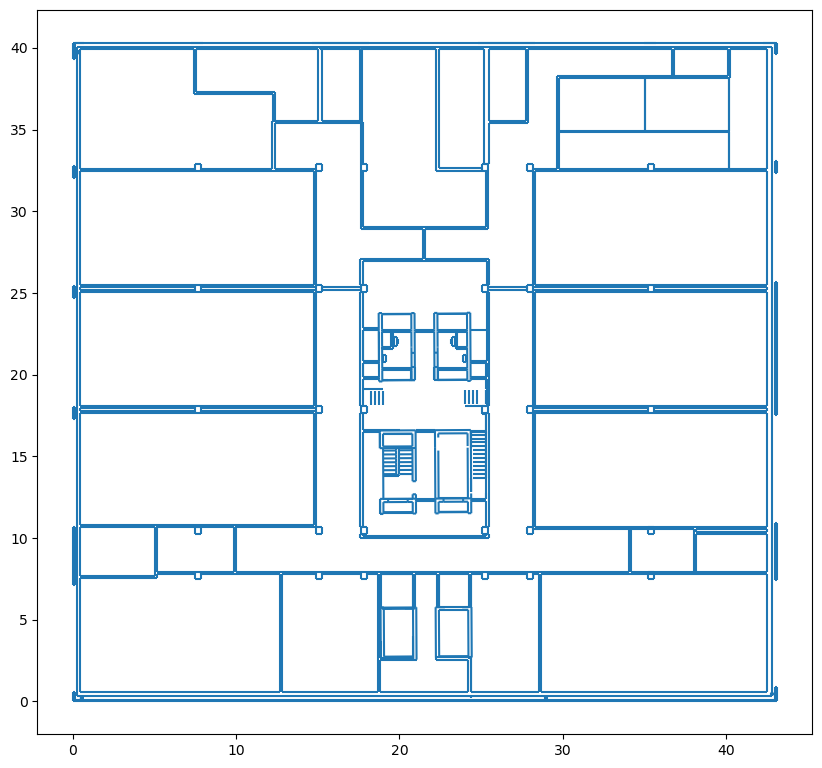

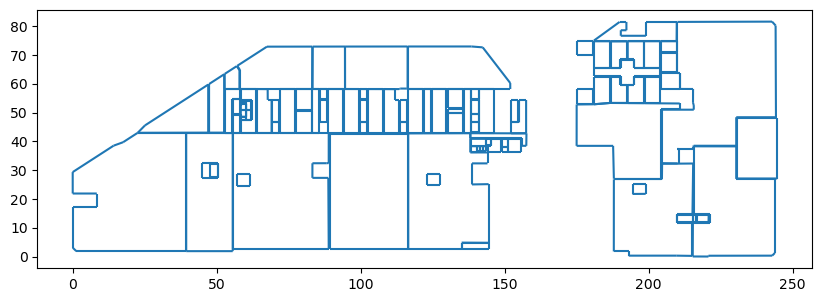

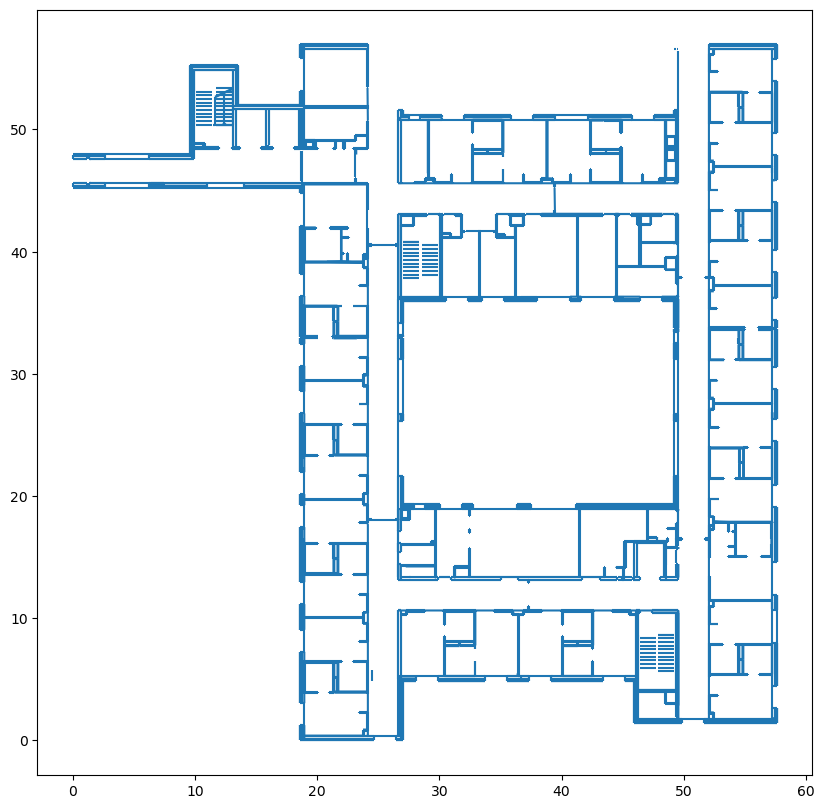

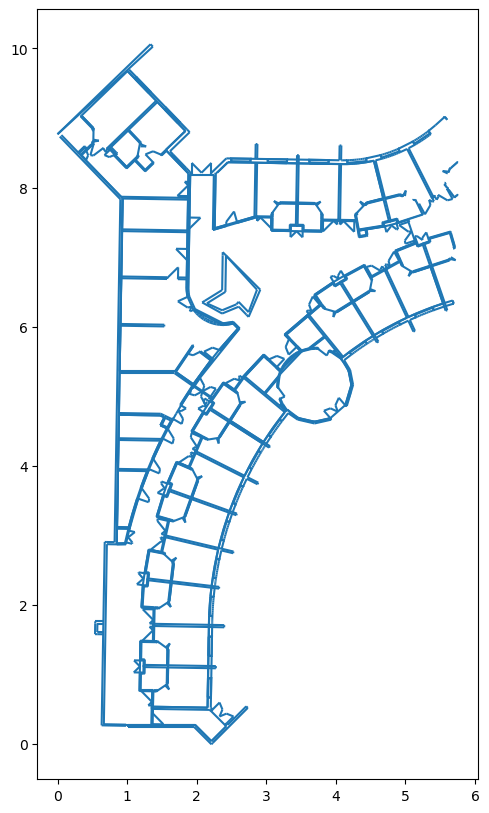

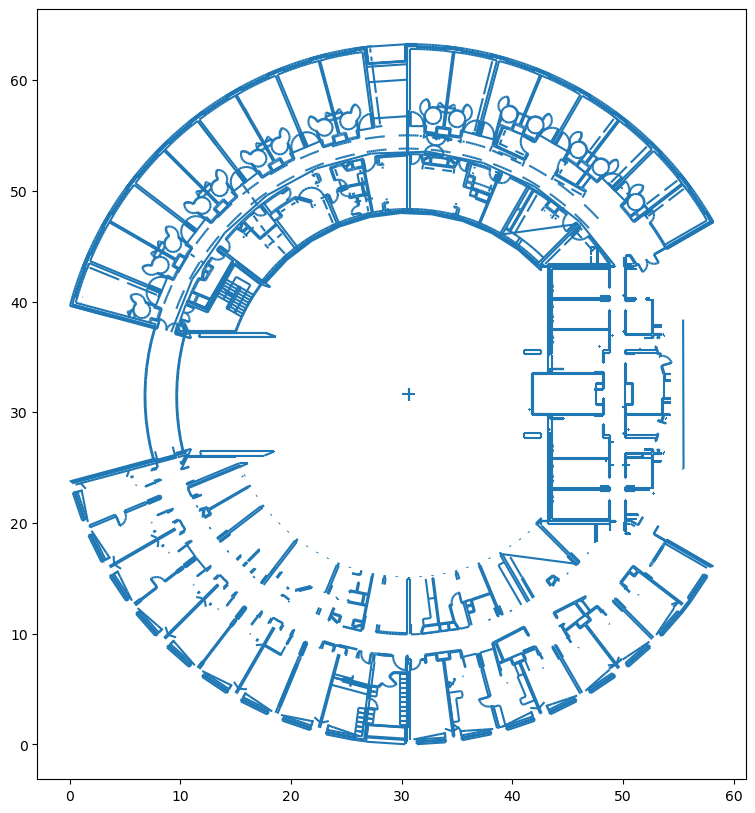

In [3]:
#Plot the segments
for i, segment in enumerate(segments):
    pg.plot_GeometryCollection(segment, figsize=(10, 10))

In [4]:
# Génération des images en noir et blanc à partir des segments et sauvegarde des métadonnées de transformation

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json
from PIL import Image
import cv2
import cv2.ximgproc  # Module pour l'affinage des lignes

# Désactiver la limite de pixels pour éviter DecompressionBombError
Image.MAX_IMAGE_PIXELS = None

# Dossier de sortie
input_dir = Path("data/output_images")
geojson_output_dir = Path("data/output_geojson_inverse")

# Échelle par défaut : 1 pixel = 1 cm² (1m = 100 pixels)
default_scale = 100

def generate_binary_image(segment, transform_parameter, output_path, scale=default_scale, thickness=1, method='ellipse'):
    """
    Génère une image binaire à partir d'un segment et sauvegarde les métadonnées.
    `thickness` permet de définir l'épaisseur des lignes en pixels.
    `method` définit la méthode de dilatation : 'ellipse', 'cross', 'gaussian'.
    """
    if len(segment.geoms) == 0:
        print(f"Skipping: No geometries found.")
        return
    
    # Déterminer les bornes
    minx, miny, maxx, maxy = segment.bounds
    width = int((maxx - minx) * scale) + 1
    height = int((maxy - miny) * scale) + 1
    
    # Sauvegarder les paramètres de transformation
    metadata_path = output_path.with_suffix(".json")
    with open(metadata_path, "w", encoding="utf-8") as f:
        json.dump({"transform_parameters": transform_parameter, "dpi_scale": scale}, f, indent=4)
    
    # Création de l'image binaire
    img = np.ones((height, width), dtype=np.uint8) * 255  # Fond blanc
    
    # Tracer les segments avec OpenCV
    for line in segment.geoms:
        x_vals, y_vals = line.xy
        x_pixels = ((np.array(x_vals) - minx) * scale).astype(int)
        y_pixels = height - ((np.array(y_vals) - miny) * scale).astype(int)
        
        for j in range(len(x_pixels) - 1):
            pt1 = (x_pixels[j], y_pixels[j])
            pt2 = (x_pixels[j + 1], y_pixels[j + 1])
            if 0 <= pt1[0] < width and 0 <= pt1[1] < height and 0 <= pt2[0] < width and 0 <= pt2[1] < height:
                cv2.line(img, pt1, pt2, 0, thickness)  # Épaisseur personnalisée
    
    # Épaississement avec méthode choisie
    if thickness > 1:
        if method == 'ellipse':
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (thickness, thickness))
        elif method == 'cross':
            kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (thickness, thickness))
        elif method == 'gaussian':
            img = cv2.GaussianBlur(img, (thickness, thickness), 0)
            _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
        else:  # Méthode par défaut (ellipse)
            kernel = np.ones((thickness, thickness), np.uint8)
        if method != 'gaussian':
            img = cv2.dilate(img, kernel, iterations=1)
    
    # Sauvegarde de l'image binaire propre
    binary_image = Image.fromarray(img)
    binary_image.save(output_path)
    
    print(f"Saved binary map: {output_path}")
    print(f"Saved transform metadata: {metadata_path}")


In [5]:
# Exemple d'utilisation avec un DPI ajustable et épaisseur des traits
dpi_choice = 50  # Changer la résolution ici (ex: 30, 50, 100...)
thickness_choice = 3  # Épaisseur des lignes en pixels (impair de préférence)
scale = dpi_choice  # 1m = dpi_choice pixels

# Méthode de dilatation ('ellipse', 'cross', 'gaussian')
method_choice = 'gaussian'

# Génération des images avec le DPI et épaisseur des traits choisis
for i, segment in enumerate(segments):
    generate_binary_image(
        segment,
        transform_parameters[i],
        input_dir / f"Output{i}_binary.png",
        scale=scale,
        thickness=thickness_choice,
        method=method_choice
    )


Saved binary map: data/output_images/Output0_binary.png
Saved transform metadata: data/output_images/Output0_binary.json
Saved binary map: data/output_images/Output1_binary.png
Saved transform metadata: data/output_images/Output1_binary.json
Saved binary map: data/output_images/Output2_binary.png
Saved transform metadata: data/output_images/Output2_binary.json
Saved binary map: data/output_images/Output3_binary.png
Saved transform metadata: data/output_images/Output3_binary.json
Saved binary map: data/output_images/Output4_binary.png
Saved transform metadata: data/output_images/Output4_binary.json
Saved binary map: data/output_images/Output5_binary.png
Saved transform metadata: data/output_images/Output5_binary.json
Saved binary map: data/output_images/Output6_binary.png
Saved transform metadata: data/output_images/Output6_binary.json
Saved binary map: data/output_images/Output7_binary.png
Saved transform metadata: data/output_images/Output7_binary.json
Saved binary map: data/output_im

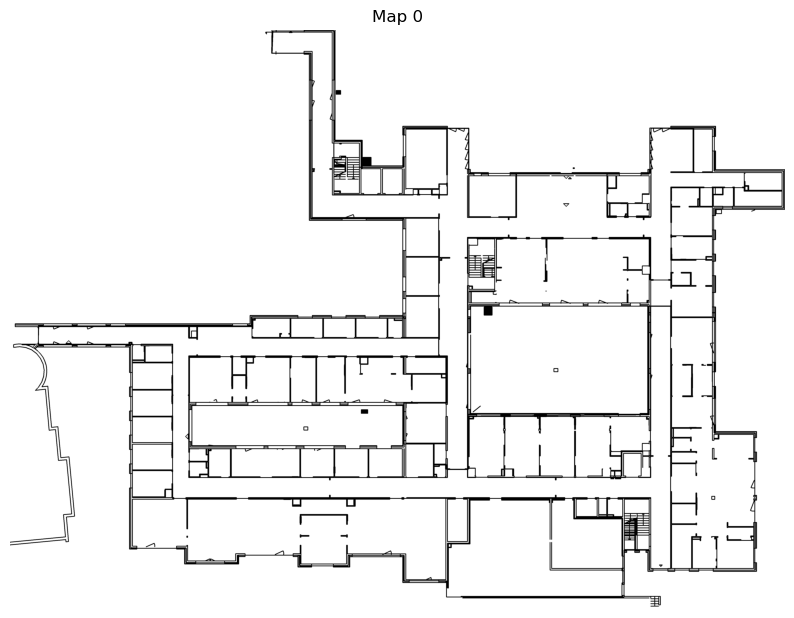

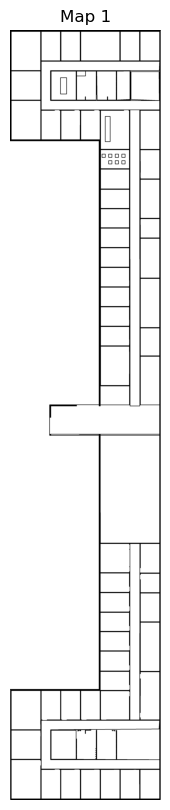

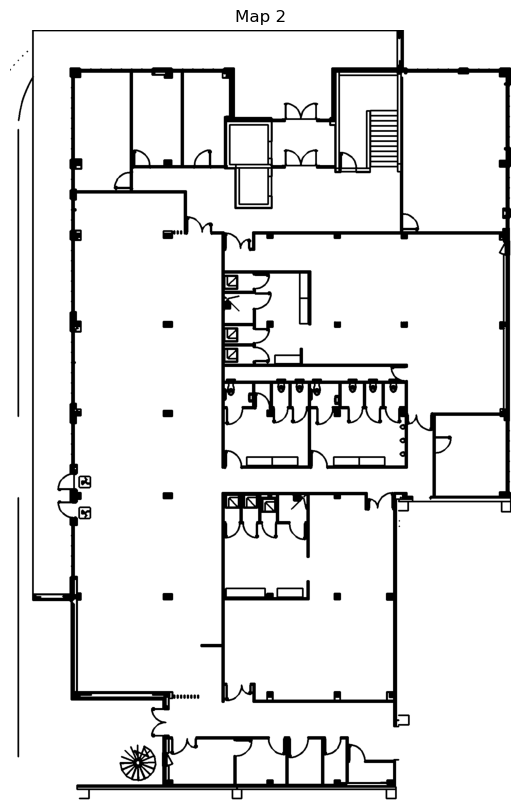

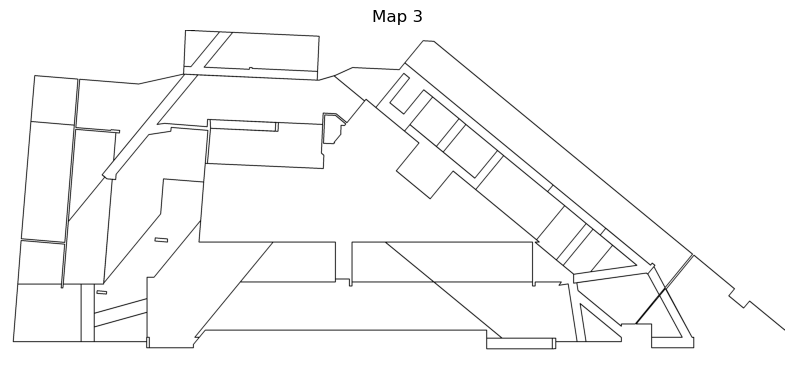

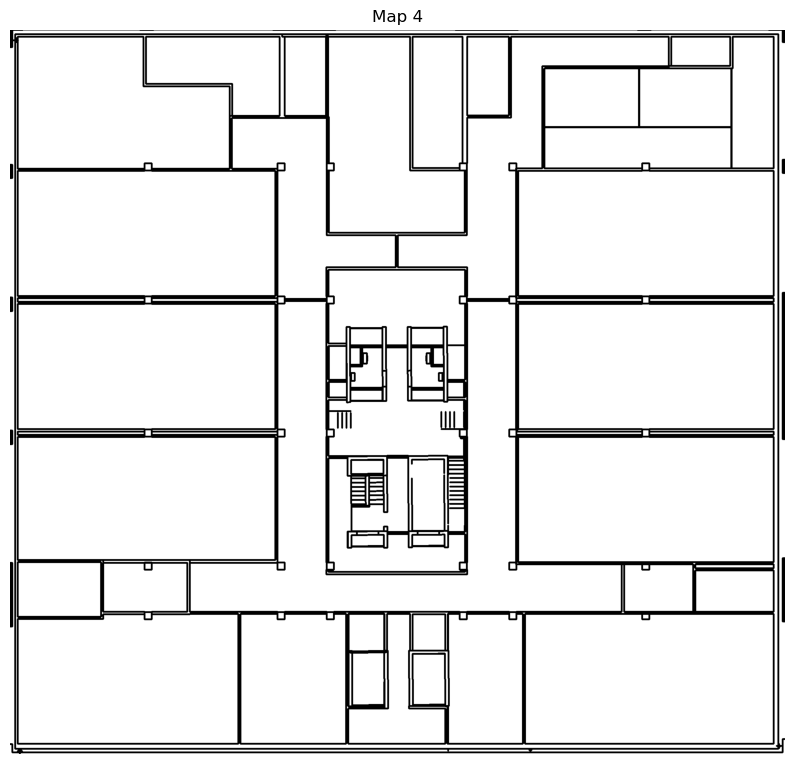

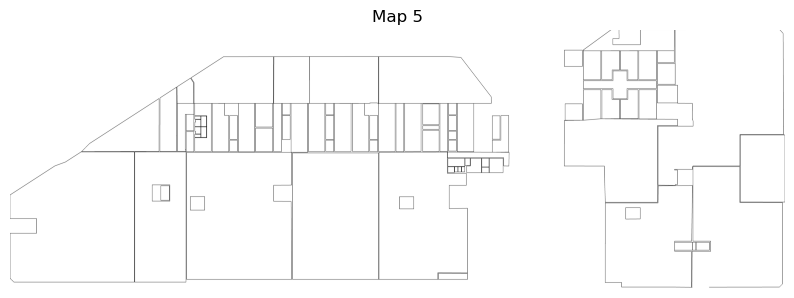

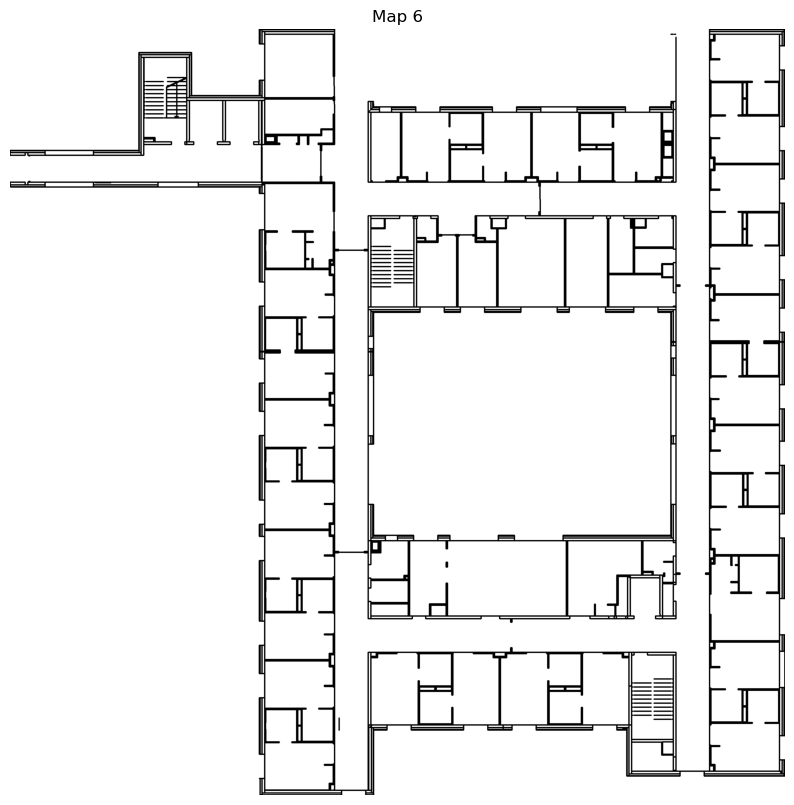

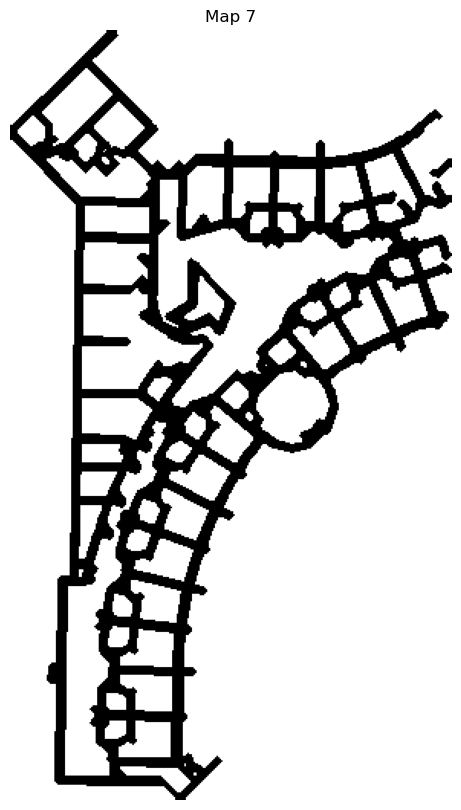

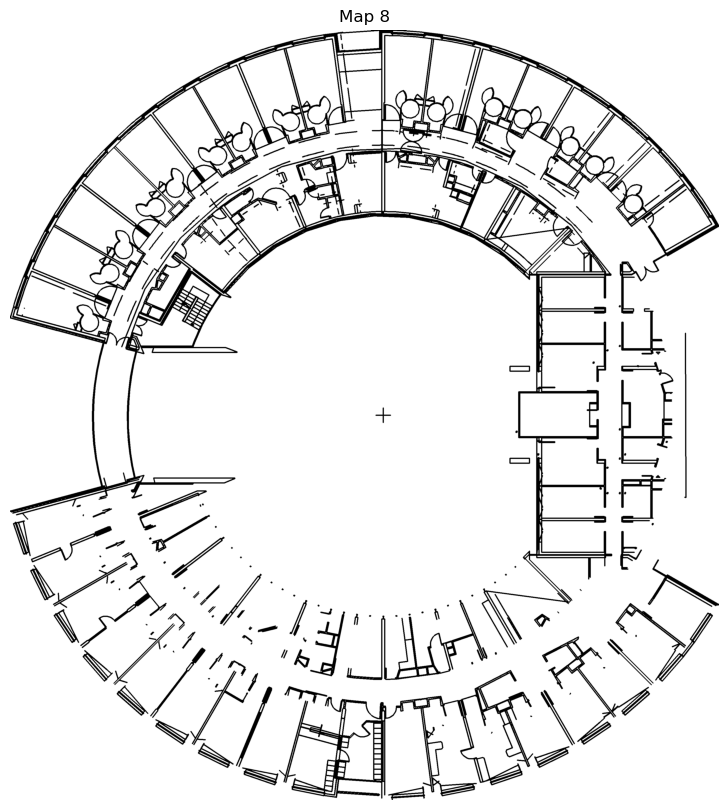

In [6]:
output_dir = Path("data", "output_images")

# Afficher les images binaires
for i in range(9):
    image_path = output_dir / f"Output{i}_binary.png"
    binary_image = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(binary_image, cmap="gray")
    plt.axis("off")
    plt.title(f"Map {i}")
    plt.show()

Suppression du polygone le plus long (murs extérieurs) avec une longueur de : 29558.60963010788 pixels
Nombre de pièces détectées pour data/output_images/Output0_binary.png : 67


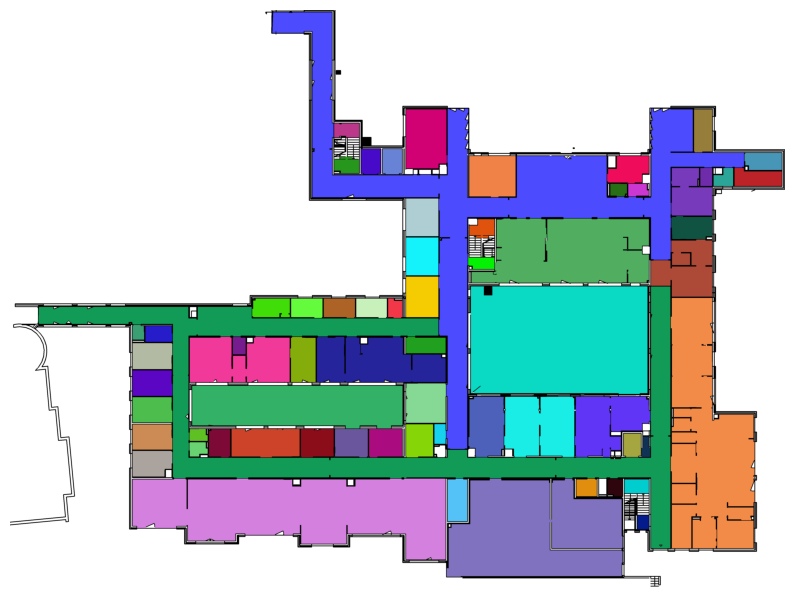

GeoJSON avec échelle enregistré : Fabien_contours_geojson/Output0_binary_scaled.geojson
Suppression du polygone le plus long (murs extérieurs) avec une longueur de : 19343.31370830536 pixels
Nombre de pièces détectées pour data/output_images/Output1_binary.png : 76


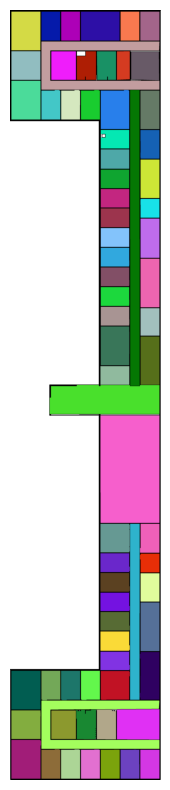

GeoJSON avec échelle enregistré : Fabien_contours_geojson/Output1_binary_scaled.geojson
Suppression du polygone le plus long (murs extérieurs) avec une longueur de : 16918.66729283333 pixels
Nombre de pièces détectées pour data/output_images/Output2_binary.png : 26


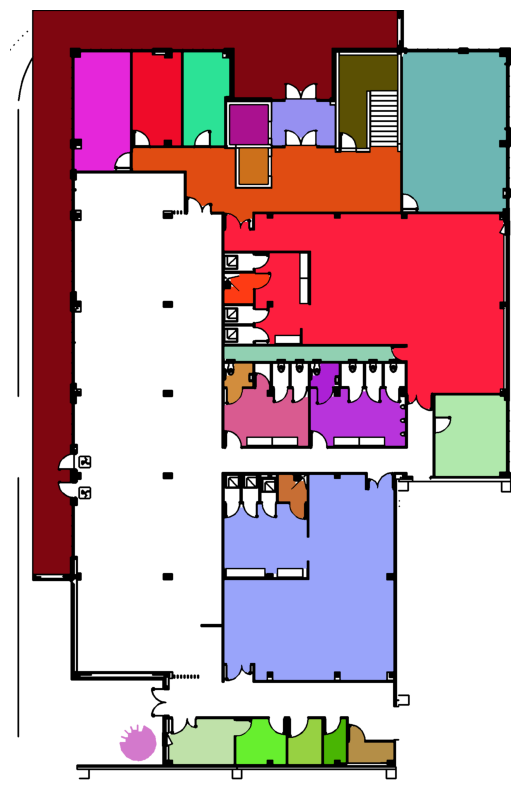

GeoJSON avec échelle enregistré : Fabien_contours_geojson/Output2_binary_scaled.geojson
Suppression du polygone le plus long (murs extérieurs) avec une longueur de : 21131.092143058777 pixels
Nombre de pièces détectées pour data/output_images/Output3_binary.png : 46


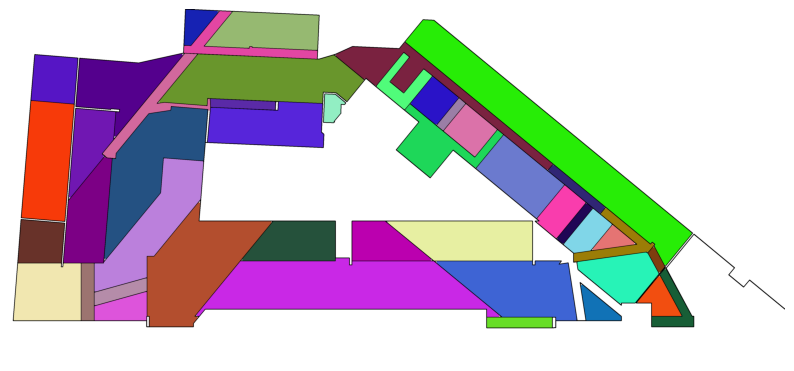

GeoJSON avec échelle enregistré : Fabien_contours_geojson/Output3_binary_scaled.geojson
Suppression du polygone le plus long (murs extérieurs) avec une longueur de : 8590.769551992416 pixels
Nombre de pièces détectées pour data/output_images/Output4_binary.png : 41


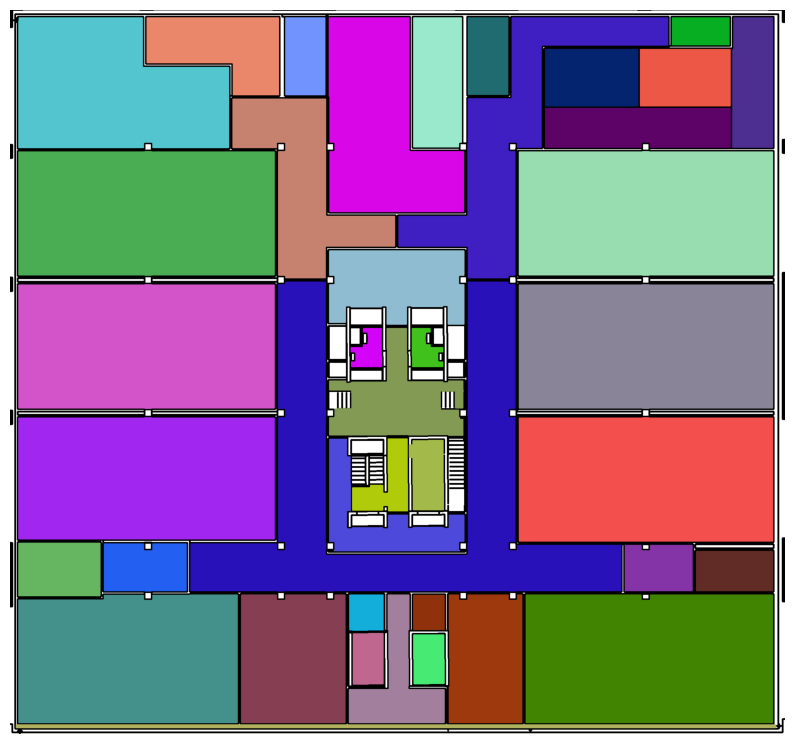

GeoJSON avec échelle enregistré : Fabien_contours_geojson/Output4_binary_scaled.geojson
Suppression du polygone le plus long (murs extérieurs) avec une longueur de : 37410.59412968159 pixels
Nombre de pièces détectées pour data/output_images/Output5_binary.png : 110


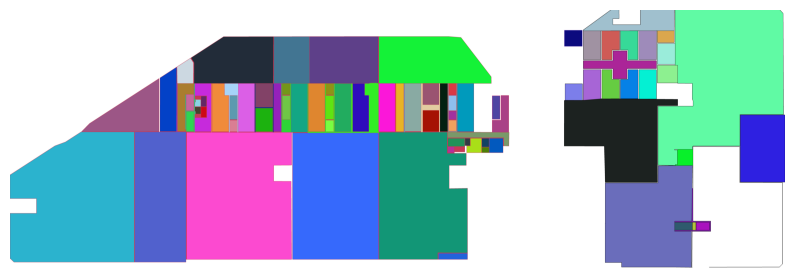

GeoJSON avec échelle enregistré : Fabien_contours_geojson/Output5_binary_scaled.geojson
Suppression du polygone le plus long (murs extérieurs) avec une longueur de : 30609.501649022102 pixels
Nombre de pièces détectées pour data/output_images/Output6_binary.png : 55


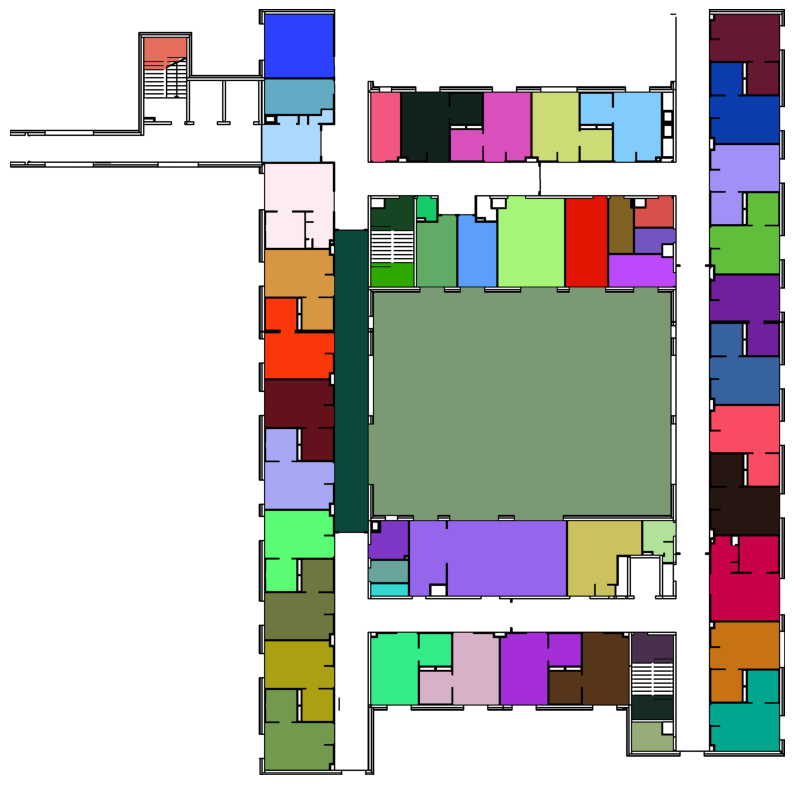

GeoJSON avec échelle enregistré : Fabien_contours_geojson/Output6_binary_scaled.geojson
Suppression du polygone le plus long (murs extérieurs) avec une longueur de : 1810.8813762664795 pixels
Nombre de pièces détectées pour data/output_images/Output7_binary.png : 1


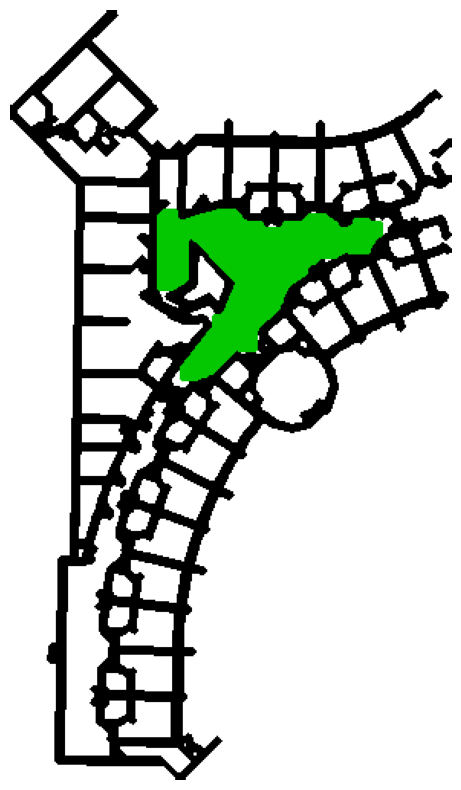

GeoJSON avec échelle enregistré : Fabien_contours_geojson/Output7_binary_scaled.geojson
Suppression du polygone le plus long (murs extérieurs) avec une longueur de : 27167.039813399315 pixels
Nombre de pièces détectées pour data/output_images/Output8_binary.png : 79


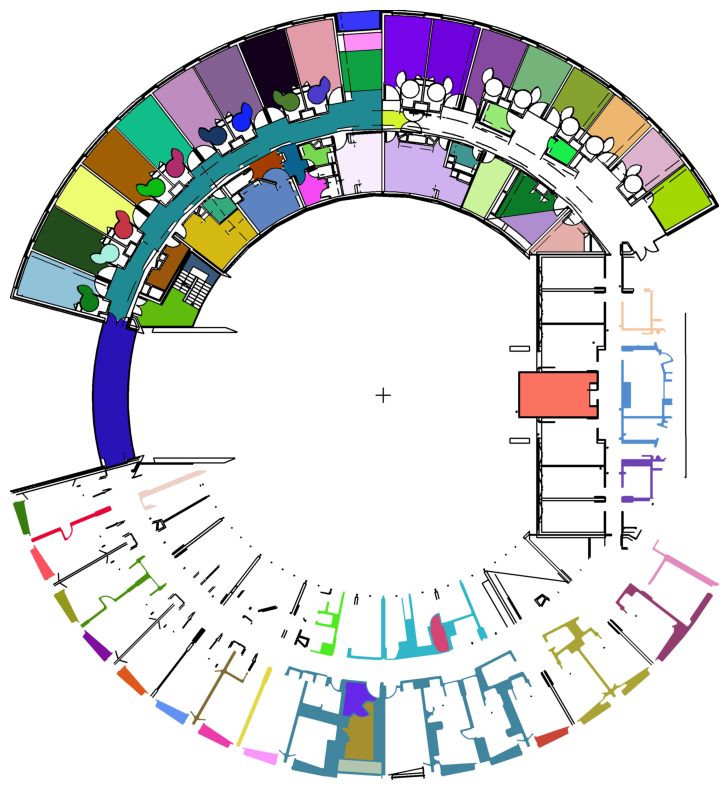

GeoJSON avec échelle enregistré : Fabien_contours_geojson/Output8_binary_scaled.geojson


In [7]:
#### Détection des contours des pièces - impression pour visualisation - création du fichier GeoJSON à l'échelle et aux coordonnées initiales


import cv2
import numpy as np
import json
import os
import matplotlib.pyplot as plt

# Charger les paramètres de transformation à partir du fichier JSON
def charger_parametres_transformation(json_path):
    with open(json_path, 'r') as f:
        transform_data = json.load(f)
    transform_parameters = transform_data["transform_parameters"]
    dpi_scale = transform_data["dpi_scale"]  # 1m = 50 pixels (ou autre valeur)
    return transform_parameters, dpi_scale

# Fonction pour convertir les coordonnées pixels en coordonnées réelles
def pixel_to_real(x, y, x_offset, y_offset, scale_factor, hauteur_totale):
    x_real = x / scale_factor + x_offset
    y_real = (hauteur_totale - y) / scale_factor + y_offset  # Inversion de Y
    return [x_real, y_real]

# Fonction pour calculer la longueur de chaque contour
def calculer_longueur_contours(contours):
    longueurs = [cv2.arcLength(contour, True) for contour in contours]
    return longueurs

def filtrer_par_surface(contours, surface_minimale):
    return [contour for contour in contours if cv2.contourArea(contour) >= surface_minimale]

# Fonction pour supprimer le polygone le plus long -> murs extérieurs
def supprimer_polygone_le_plus_long(contours):
    longueurs = calculer_longueur_contours(contours)
    index_max = np.argmax(longueurs)
    print(f"Suppression du polygone le plus long (murs extérieurs) avec une longueur de : {longueurs[index_max]} pixels")
    contours.pop(index_max)
    return contours

# Fonction pour convertir les contours en format GeoJSON avec échelle et transformation
def contours_to_geojson(contours, image_name, hauteur_totale, surface_minimale, x_offset, y_offset, scale_factor, dpi_scale):   
    # Structure GeoJSON
    geojson = {
        "type": "FeatureCollection",
        "features": []
    }

    # Parcours des contours pour les convertir en polygones GeoJSON
    for contour in contours:
        # Calcul de la surface de chaque contour
        surface = cv2.contourArea(contour)

        # Filtrer par surface minimale
        if surface >= surface_minimale:
            # Extraction des points du contour
            coords = contour.squeeze().tolist()

            # Conversion des coordonnées pixels en coordonnées réelles
            real_coords = [pixel_to_real(x, y, x_offset, y_offset, scale_factor, hauteur_totale) for x, y in coords]

            # Fermeture du polygone en répétant le premier point à la fin
            real_coords.append(real_coords[0])
            
            # Construction du polygone GeoJSON
            polygon = {
                "type": "Feature",
                "properties": {
                    "surface_px": surface,
                    "surface_m2": surface / (dpi_scale**2),  # Conversion en m²
                    "image": image_name
                },
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [real_coords]
                }
            }
            geojson["features"].append(polygon)

    # Sauvegarde du GeoJSON dans un fichier
    output_dir = "Fabien_contours_geojson"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"{image_name}_scaled.geojson")
    with open(output_path, 'w') as geojson_file:
        json.dump(geojson, geojson_file, indent=4)
    
    print(f"GeoJSON avec échelle enregistré : {output_path}")

# Fonction principale pour générer les pièces et exporter en GeoJSON
def generer_pieces(image_path, json_path, surface_minimale=5000):
    # Charger les paramètres de transformation
    transform_parameters, dpi_scale = charger_parametres_transformation(json_path)
    x_offset = transform_parameters[0]
    y_offset = transform_parameters[1]
    scale_factor = transform_parameters[2]*dpi_scale

    # Charger l'image en niveau de gris
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    hauteur_totale = img.shape[0]  # Hauteur totale de l'image en pixels

    # Appliquer un seuillage pour binariser l'image
    _, binary_improved = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY_INV)

    # Application d'une fermeture morphologique pour mieux détecter les contours internes
    kernel = np.ones((5, 5), np.uint8)
    closed_morph = cv2.morphologyEx(binary_improved, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Détection des contours en hiérarchie avec l'image traitée
    contours_hierarchy_morph = list(cv2.findContours(closed_morph, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)[0])
    contours_hierarchy_morph = filtrer_par_surface(contours_hierarchy_morph, surface_minimale)

    # Suppression du polygone avec la longueur maximale (murs extérieurs)
    contours_hierarchy_morph = supprimer_polygone_le_plus_long(contours_hierarchy_morph)

    # Réinitialisation de l'image couleur pour la coloration
    color_img_area = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Initialisation du compteur de pièces
    compteur_pieces = 0

    # Parcours des contours hiérarchiques pour colorer uniquement les pièces assez grandes
    for i, contour in enumerate(contours_hierarchy_morph):
        # Calcul de la surface de chaque contour
        surface = cv2.contourArea(contour)

        # Appliquer le filtre de surface minimale
        if surface >= surface_minimale:
            # Choix d'une couleur aléatoire pour chaque pièce
            color = np.random.randint(0, 255, 3).tolist()
            cv2.drawContours(color_img_area, [contour], -1, color, thickness=cv2.FILLED)
            
            # Incrémenter le compteur de pièces
            compteur_pieces += 1

    # Affichage du nombre de pièces détectées
    print(f"Nombre de pièces détectées pour {image_path} : {compteur_pieces}")

    # Affichage du résultat
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(color_img_area, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Export des contours en GeoJSON avec échelle appliquée
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    contours_to_geojson(contours_hierarchy_morph, image_name, hauteur_totale, surface_minimale, x_offset, y_offset, scale_factor, dpi_scale)

# Exécution du traitement sur l'ensemble des images binaires

for i in range(9):
    generer_pieces(
        input_dir / f"Output{i}_binary.png",
        input_dir / f"Output{i}_binary.json",
        surface_minimale=5000
    )

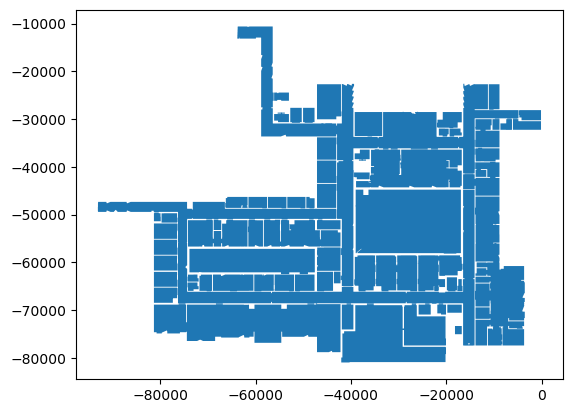

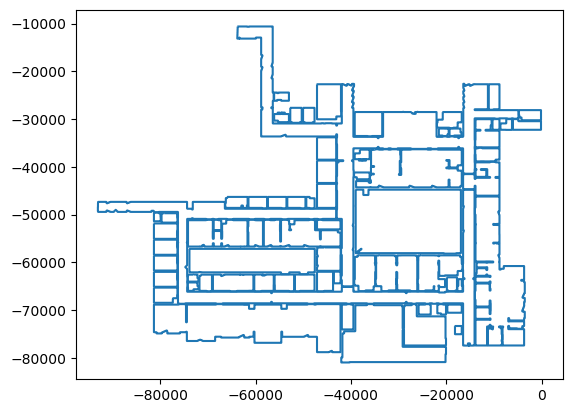

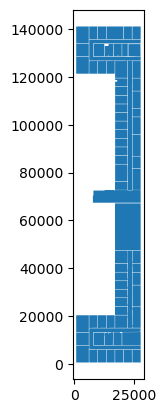

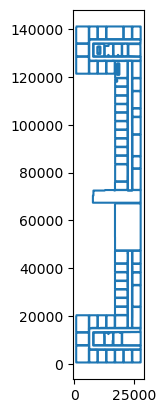

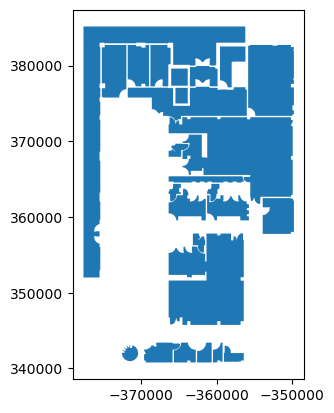

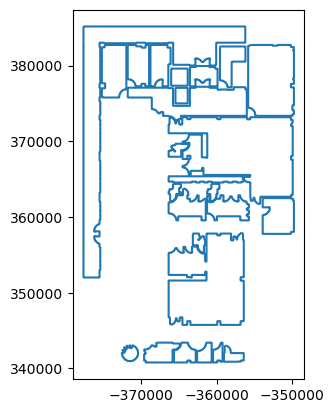

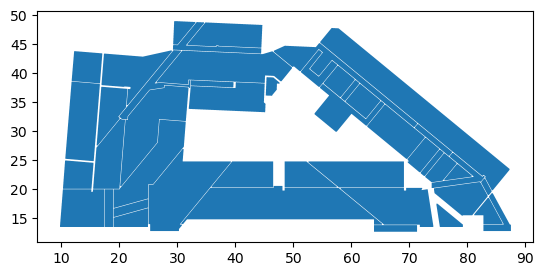

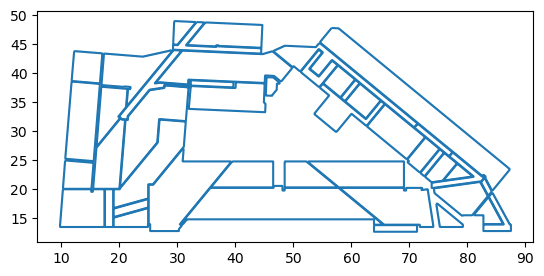

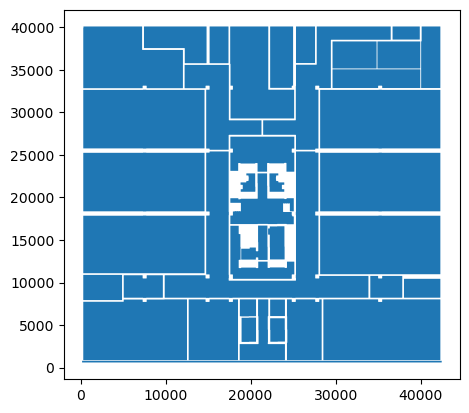

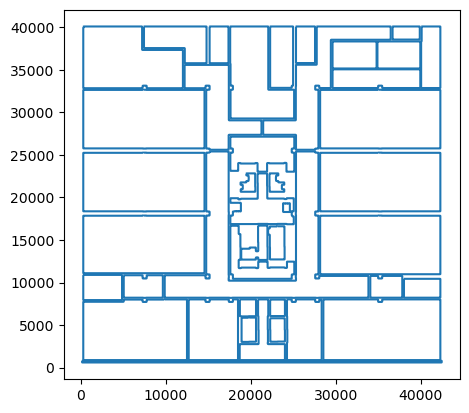

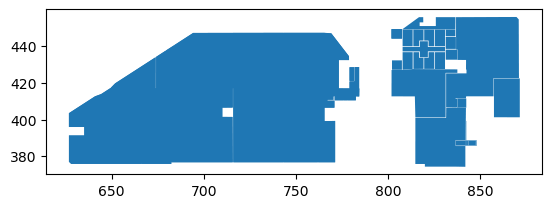

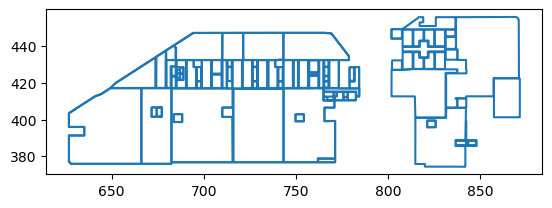

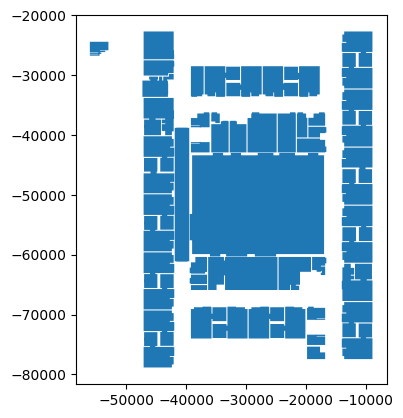

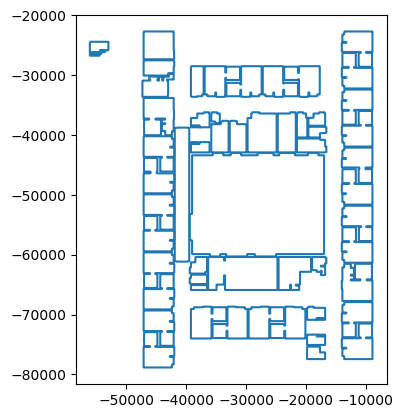

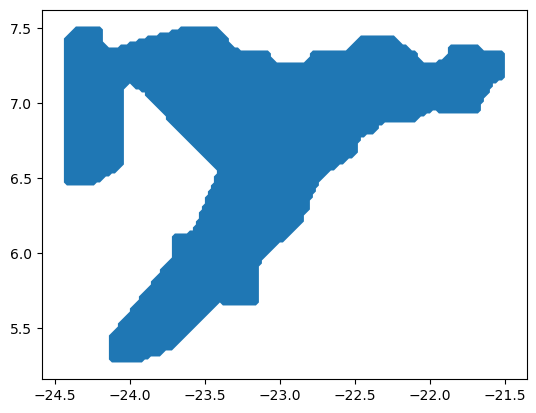

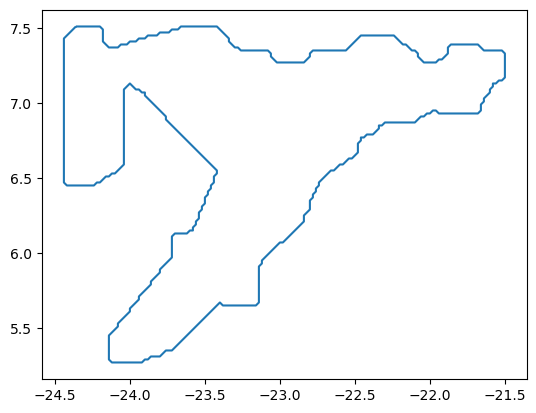

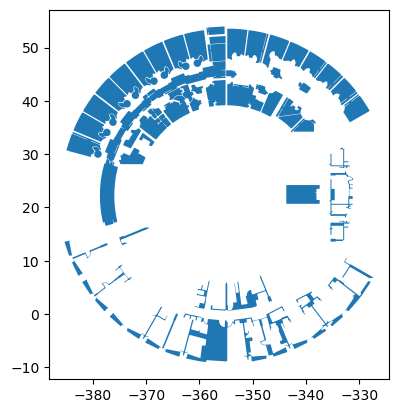

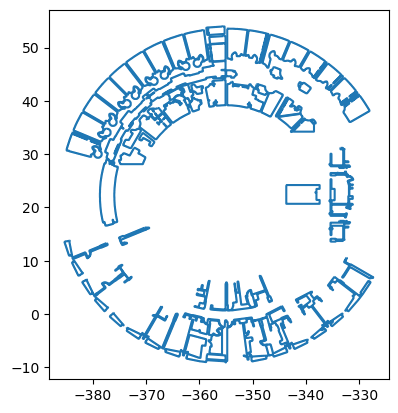

In [8]:
# Imprime les geojson avec les contours des pièces

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Polygon, MultiLineString
from pathlib import Path

for i in range (9):
    path = Path(f"Fabien_contours_geojson/Output{i}_binary_scaled.geojson")
    gdf = gpd.GeoDataFrame.from_file(path)
    gdf.plot(aspect=1)
    gdf.boundary.plot(aspect=1)